# Sample raster values at shapefile points

### In Anaconda Prompt
```
conda create --name raster -c conda-forge rasterstats jupyterlab geopandas matplotlib descartes
conda activate raster
jupyter lab
```

In [1]:
from rasterstats import zonal_stats, point_query
import rasterio
from rasterio.plot import show, show_hist
from shapely.geometry import Point
import geopandas as gpd

## Reading zipped ASCII file

https://rasterio.readthedocs.io/en/stable/topics/datasets.html

In [2]:
pm25 = rasterio.open('zip://data/GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc.zip!/GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc')
pm25.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -999.9000244140625,
 'width': 9300,
 'height': 4550,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.01, 0.0, -138.0,
        0.0, -0.01, 68.0)}

## Reading NetCDF file

In [3]:
pm25_nc = rasterio.open('data/GWRwSPEC_PM25_NA_200001_200012-RH35.nc')
pm25_nc.meta

{'driver': 'netCDF',
 'dtype': 'float32',
 'nodata': 9.969209968386869e+36,
 'width': 9300,
 'height': 4550,
 'count': 1,
 'crs': None,
 'transform': Affine(0.009999999360046485, 0.0, -137.99999511686752,
        0.0, -0.010000000788264548, 68.00000274697616)}

In [4]:
pm25.crs.__class__

rasterio.crs.CRS

---

### Viewing raster data

vmin, vmax set the max and min for color scale

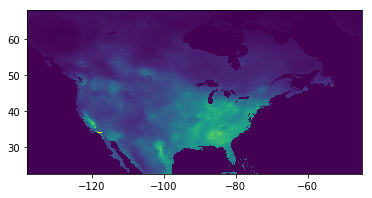

In [72]:
show((pm25,1), transform=pm25.transform, vmin=1, cmap='viridis')

## Reading shapefile into GeoDataFrame

Takes just slightly longer reading from a zipped shapefile (14 sec vs 13 on desktop Mac)

In [2]:
df = gpd.read_file('zip://data/popctr_blkgrp2010.zip')

In [6]:
df.shape

(220334, 9)

In [7]:
df.head()

,FIPS,STATE,COUNTY,TRACT,BLKGRP,POPULATION,LATITUDE,LONGITUDE,geometry
0,010010201001,01,001,020100,1,698,32.464812,-86.486527,POINT (-86.48653 32.46481)
1,010010201002,01,001,020100,2,1214,32.482391,-86.486912,POINT (-86.48691 32.48239)
2,010010202001,01,001,020200,1,1003,32.478035,-86.474786,POINT (-86.47479 32.47803)
3,010010202002,01,001,020200,2,1167,32.466372,-86.471060,POINT (-86.47106 32.46637)
4,010010203001,01,001,020300,1,2549,32.476828,-86.460326,POINT (-86.46033 32.47683)


In [8]:
df.crs

{'init': 'epsg:4269'}

---

### Pandas geometry objects can be plotted

- **matplotlib** is required for general plotting with points
- **descartes** package is required for plotting polygons (but doesn't need to be explicitly imported)

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

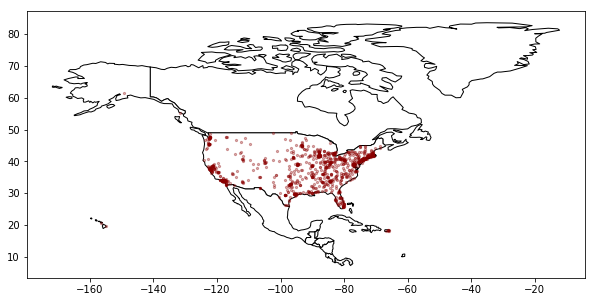

In [60]:
# We restrict background polygons to North America
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(10,10))

# We can now plot the points in our GeoDataFrame
df['geometry'].sample(n=1000).plot(ax=ax, markersize=5, alpha=0.33, color='darkred');

#### CRS (coordinate reference system)

- epsg:4326 - WGS84 (World Geodetic System 1984) – lat/lon (hand-coded)
- epsg:4269 - NAD83 (North American Datum 1983)

---

## Point queries

Reading raster data into Numpy ndarray takes a few seconds the first time through

In [10]:
raster_data = pm25.read(1)

#### 20k points – 4.5 sec laptop, 3 sec DVS lab

In [11]:
pts = point_query(df.loc[:20000,'geometry'], raster_data, affine=pm25.transform, nodata=-999)
pts[:10]

[16.299999237060547,
 16.299999237060547,
 16.19851024725351,
 16.246879944502222,
 16.1097363466093,
 16.12439381652304,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727]

#### All 220k points – 52 sec laptop, 36 sec DVS lab

In [12]:
df['pm25'] = point_query(df['geometry'], raster_data, affine=pm25.transform, nodata=-999)
df.head()

,FIPS,STATE,COUNTY,TRACT,BLKGRP,POPULATION,LATITUDE,LONGITUDE,geometry,pm25
0,010010201001,01,001,020100,1,698,32.464812,-86.486527,POINT (-86.48653 32.46481),16.299999
1,010010201002,01,001,020100,2,1214,32.482391,-86.486912,POINT (-86.48691 32.48239),16.299999
2,010010202001,01,001,020200,1,1003,32.478035,-86.474786,POINT (-86.47479 32.47803),16.198510
3,010010202002,01,001,020200,2,1167,32.466372,-86.471060,POINT (-86.47106 32.46637),16.246880
4,010010203001,01,001,020300,1,2549,32.476828,-86.460326,POINT (-86.46033 32.47683),16.109736


## Testing whether it makes a difference to reproject point data

#### 6 sec laptop, 4 sec DVS lab

In [13]:
df_proj = df.to_crs(pm25.crs)
df_proj.crs

CRS.from_epsg(4326)

## Projection doesn't seem to matter

It must be basing the calculation only on the Affine() since the reprojection doesn't matter, and because the CRS isn't even available to `point_query()`.

#### 4.5 sec laptop, 3 sec DVS lab

In [14]:
pts = point_query(df_proj.loc[:20000,'geometry'], raster_data, affine=pm25.transform, nodata=-999)
pts[:10]

[16.299999237060547,
 16.299999237060547,
 16.19851024725351,
 16.246879944502222,
 16.1097363466093,
 16.12439381652304,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727]

---

## Using NetCDF instead

Doesn't seem to matter that the NetCDF version doesn't have a CRS attached.

#### 20k points – 5 sec laptop, 3 sec DVS lab

In [15]:
raster_nc = pm25_nc.read(1)

In [16]:
pts = point_query(df.loc[:20000,'geometry'], raster_nc, affine=pm25_nc.transform, nodata=-999)
pts[:10]

[16.299999237060547,
 16.299999237060547,
 16.198521303380947,
 16.24689525936792,
 16.109739527068022,
 16.124409056380433,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727,
 16.100000381469727]